In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

haremos en este problemset una implementación del método de _Bag of features_, sobre el dataset MNIST

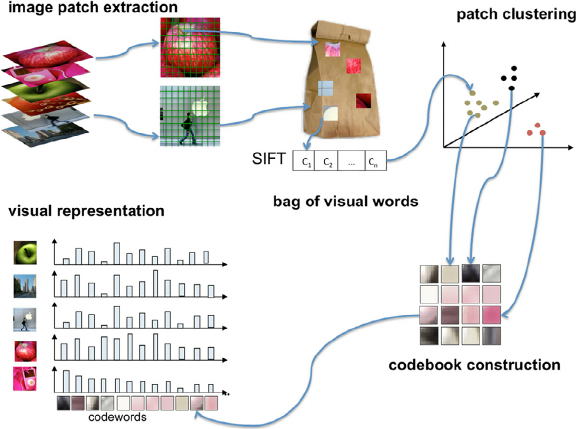

In [2]:
Image(filename='local/imgs/bof.png')

ejecuta las siguientes celdas para cargar MNIST y ver una muestra del mismo.

In [4]:
mnist = np.loadtxt("local/data/mnist1.5k.csv", delimiter=",")
print ("dimension de los datos originales", mnist.shape)
X=mnist[:,1:785]
y=mnist[:,0]

dimension de los datos originales (1500, 785)


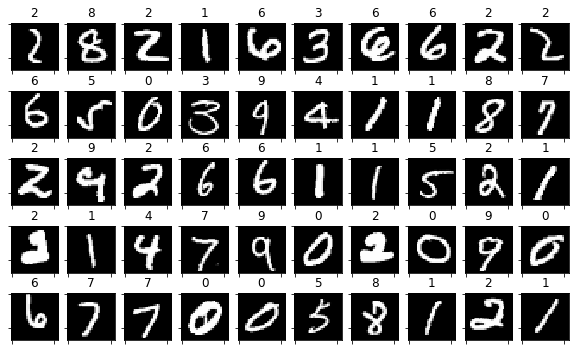

In [5]:
perm = np.random.permutation(range(X.shape[0]))[0:50]
random_imgs   = X[perm]
random_labels = y[perm] 
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

## Ejercicio 1: Extracción de parches

completa la siguiente función para que dada una imagen en escala de grises ($\in [0,255]^{h\times w}$), extraiga parches de tamaño cuadrado de la misma, con un tamaño de paso concreto, tendiendo en cuenta que:

- los parches cuya suma de valores sean cero sólo deberán de ser incluidos sin `include_empy_patches` es verdadero.
- sólo se incluirán parches completos (es decir, de tamaño `patch_size` $\times$ `patch_size`)

Por ejemplo, para la siguiente imagen:

           img= [[5 8 2 4 1 4 6 8 0 6 1]
                 [3 8 1 4 3 5 6 9 3 1 7]
                 [8 7 3 4 2 7 6 0 9 3 8]
                 [4 7 3 2 7 2 4 7 5 0 5]
                 [9 8 7 6 5 1 8 7 0 6 4]
                 [0 3 8 4 7 0 0 3 5 5 2]
                 [5 4 3 2 1 0 0 8 8 2 8]
                 [8 3 7 8 2 5 0 3 8 2 4]
                 [6 7 2 8 0 0 1 7 5 4 8]]
         
la ejecución de `extract_patches(img, 2,5)` da tres parches (el parche con cuatro 0's se excluye por `include_empty_patches=False`):

        [[5 8]   [[4 6]   [[0 3]
         [3 8]]   [5 6]]   [5 4]]

In [6]:
def extract_patches(img, patch_size, step_size, include_empty_patches=False):
    patches = []
    for y in range(0, img.shape[0]-patch_size+1, step_size):
        for x in range(0, img.shape[1]-patch_size+1, step_size):
            patch = img[y:y+patch_size,x:x+patch_size]
            if patch.shape==(patch_size, patch_size) and (include_empty_patches or np.sum(patch)!=0):
                patches.append(patch)
    return patches


comprueba tu código

In [7]:
img = np.array([[5, 8, 2, 4, 1, 4, 6, 8, 0, 6, 1],
       [3, 8, 1, 4, 3, 5, 6, 9, 3, 1, 7],
       [8, 7, 3, 4, 2, 7, 6, 0, 9, 3, 8],
       [4, 7, 3, 2, 7, 2, 4, 7, 5, 0, 5],
       [9, 8, 7, 6, 5, 1, 8, 7, 0, 6, 4],
       [0, 3, 8, 4, 7, 0, 0, 3, 5, 5, 2],
       [5, 4, 3, 2, 1, 0, 0, 8, 8, 2, 8],
       [8, 3, 7, 8, 2, 5, 0, 3, 8, 2, 4],
       [6, 7, 2, 8, 0, 0, 1, 7, 5, 4, 8]])
for i in extract_patches(img, 2,5):
    print (i)

[[5 8]
 [3 8]]
[[4 6]
 [5 6]]
[[0 3]
 [5 4]]


observa los parches extraídos de una imagen

patch extraction with empty patches 121
without empty patches 82


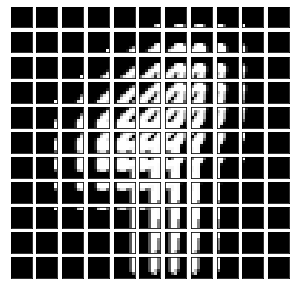

In [9]:
patch_size, step_size = 7, 2

p = extract_patches(X[1307].reshape(28,28), patch_size, step_size, include_empty_patches=True)
print ("patch extraction with empty patches", len(p))
pe = extract_patches(X[1307].reshape(28,28), patch_size, step_size)
print ("without empty patches", len(pe))
plt.figure(figsize=(5,5))
s = np.sqrt(len(p))
for i in range(len(p)):
    plt.subplot(s,s,i+1)
    plt.imshow(p[i], cmap = plt.cm.Greys_r, interpolation="nearest")
    plt.xticks([]); plt.yticks([])
plt.savefig("local/imgs/bof3.png")

## Ejercicio 2: Diccionario visual

Fíjate cómo funciona KMeans. Trata de entender el código y ejecútalo varias veces

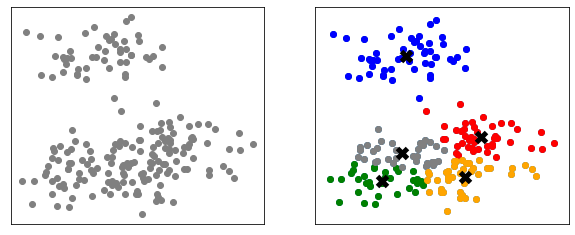

In [10]:
from sklearn.datasets import make_blobs
Xp, _ = make_blobs(n_samples=200,n_features=2, centers=4, cluster_std=2)
cols = ["red", "blue", "green", "gray", "orange"]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(Xp[:,0], Xp[:,1], color="gray")
plt.xticks([]); plt.yticks([])
plt.subplot(122)
plt.scatter(Xp[:,0], Xp[:,1])
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5)
km.fit(Xp)
y = km.predict(Xp)
for i in np.unique(y):
    plt.scatter(Xp[y==i][:,0], Xp[y==i][:,1], color=cols[i])
    plt.xticks([]); plt.yticks([]);
for i,p in enumerate(km.cluster_centers_):
    plt.scatter(p[0], p[1], s=100, c="black", marker="x", lw=5)
    plt.xticks([]); plt.yticks([]);

Vamos a hacer un KMeans con los parches extraídos de las imágenes y consideraremos los centroides como palabras visuales. Para ello, completa la función siguiente de forma que:

- tendrás que usar la función `extract_patches` del ejercicio anterior.
- construya una lista con todos parches de las imágenes de la matriz `X`. Observa que en cada file de la matriz hay una imagen linearizada y tendrás que hacer un `.reshape(28,28)` para convertirla en una matriz antes de llamar a `extract_patches`
- devuelva la lista de centroides del `KMeans`

Esta lista de centroides será nuestro **diccionario visual** y, como cada centroide tiene el mismo tamaño que los parches, los podremos visualizar.

In [11]:
def get_visual_dictionary(X, patch_size, step_size, dict_size):
    from sklearn.cluster import KMeans
    patches = []
    for img in X:
        patches += [i.reshape(patch_size**2) for i in extract_patches(img.reshape(28,28), patch_size, step_size)]

    cinit = np.zeros((dict_size, patch_size**2))
    km = KMeans(n_clusters=dict_size, init=cinit, n_init=1)#, n_jobs=24)
    km.fit(patches)
    return km.cluster_centers_


comprueba tu código. la siguiente configuración te debería de dar un conjunto de palabras visuales como este:

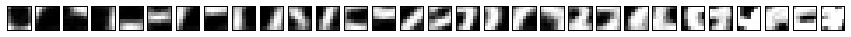

In [13]:
Image(filename='local/imgs/vwords.png')

158516.17298191477


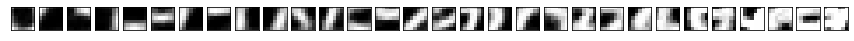

In [14]:
patch_size, step_size, dict_size = 7, 7, 30
vwords = get_visual_dictionary(X[:100], patch_size, step_size, dict_size)
plt.figure(figsize=(15,1.5))
vwords = vwords[np.argsort([np.sum(vwords[i]) for i in range(len(vwords))])]
print (np.sum([np.sum(vwords[i]) for i in range(len(vwords))]))
n = len(vwords)
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(vwords[i].reshape(patch_size,patch_size),cmap = plt.cm.Greys_r,interpolation="nearest")
    plt.xticks([]); plt.yticks([])

## Ejercicio 3: Histograma

Vamos ahora a calcular de qué palabras visuales consta cada imagen. Esta será la representación _Bag of Features_ ya que, para cada palbra visual, contaremos cuantas veces aparece en cada imagen. Esto es análogo a contar, en un documento, cuantas veces aparece cada palabra.

Para ello haremos dos funciones:

- `get_closest`: en la que dado un parche y un diccionario visual como el devuelto en el ejercicio anterior nos de la palabara visual más parecida. Esta similitud estará medida en términos de la norma L2 (`np.linalg.norm`)

- `get_histogram`:  que, dada una imagen y un diccionario, (1) extrae todos los parches de la imagen, (2) para cada parche obtiene cual es su palabra visual más similar y (3) devuelve un vector con tantos elementos como palabras visuales, con la frecuencia relativa de aparición de cada palabra visual en la imagen. La frecuencia relativa de una palabra visual $w$ viene dada por el número de parches de la imagen cuya palabra visual más similar es $w$, dividido por el número total de parches.

In [15]:
def get_closest(patch, dictionary):
    dmin, r = np.inf, None
    for i, vw in enumerate(dictionary):
        distance = np.linalg.norm(patch-vw)
        if distance<dmin:
            dmin = distance
            r = i
    return r

def get_histogram(img, patch_size, step_size, dictionary):

    patches = [i.flatten() for i in extract_patches(img, patch_size, step_size)]
    
    vws = np.array([get_closest(patch, dictionary) for patch in patches])
    h = [np.sum(vws==i) for i in range(len(dictionary))]
    return np.array(h)*1./np.sum(h)



comprueba tu código. la celda siguiente selecciona un parche al azar de una imagen al azar y muestra su palabra visual más cercana.

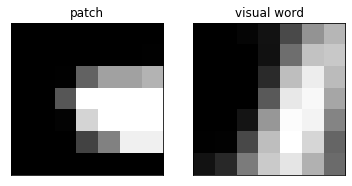

In [16]:
mnist = np.loadtxt("local/data/mnist1.5k.csv", delimiter=",")
X=mnist[:,1:785]
y=mnist[:,0]
img = X[np.random.randint(len(X))].reshape(28,28)
patches = extract_patches(img, patch_size, step_size)
patch   = patches[np.random.randint(len(patches))].reshape(patch_size**2)
vword = vwords[get_closest(patch, vwords)]

plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(patch.reshape(patch_size, patch_size),  cmap = plt.cm.Greys_r, interpolation="nearest")
plt.title("patch")
plt.xticks([]); plt.yticks([])
plt.subplot(122)
plt.title("visual word")
plt.imshow(vword.reshape(patch_size, patch_size),  cmap = plt.cm.Greys_r, interpolation="nearest")
plt.xticks([]); plt.yticks([]);

la siguiente celda selecciona una imagen al azar y obtiene su histograma de palabras visuales

404


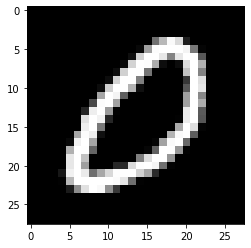

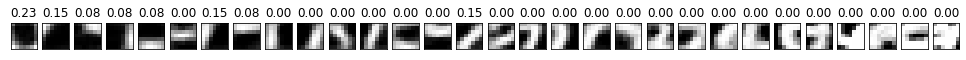

In [17]:
k = np.random.randint(len(X))
print (k)
img = X[k].reshape(28,28)
h = get_histogram(img, patch_size, step_size, vwords)
plt.imshow(img, cmap = plt.cm.Greys_r, interpolation="nearest")

plt.figure(figsize=(17,3))
n = len(vwords)
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(vwords[i].reshape(patch_size,patch_size),cmap = plt.cm.Greys_r)
    plt.title("%.2f"%h[i])
    plt.xticks([]); plt.yticks([])

## Experimenta con la nueva representación

observa cómo aumenta el porcentaje de acierto representando las imágenes con un histograma de palabras visuales. Este proceso puede demorarse varios minutos.

In [18]:
patch_size, step_size = 7,2
vdict = get_visual_dictionary(X, patch_size, step_size, 60)
Xh = [get_histogram(i.reshape(28,28), patch_size, step_size, vdict) for i in X]
Xh = np.array(Xh)

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

estimator = GaussianNB()
sc = cross_val_score(estimator, X,y,cv=5)
print ("original pixels                %.3f +/- %.3f"%(np.mean(sc), np.std(sc)))
sc = cross_val_score(estimator, Xh,y,cv=5)
print ("bag of features representation %.3f +/- %.3f"%(np.mean(sc), np.std(sc)))

original pixels                0.592 +/- 0.010
bag of features representation 0.759 +/- 0.044
